# Demo de 'Transfer Learning con TF-Hub' en el cual se logra un modelo que puede aprender a reconocer clases en imágenes usando como base un modelo ya entrenado para reconocer otros tipos de objetos
Basado en https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

1) Importar librerías:

In [1]:
#@title Librerías a usar

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pylab as plt
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import csv

print("\nLibrerías importadas")


Librerías importadas


2) Cargar el modelo a utilizar para procesar:

In [2]:
#@title Establecer el modelo a utilizar

modeloUsar = 'inception_v3' #@param ["inception_v3", "mobilenet_v2"]

print("\nModelo ", modeloUsar, "seleccionado")

# define configuración del modelo
if modeloUsar == 'inception_v3':

    # URLs donde se encuentra la info del modelo Inception v3
    classifier_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4" 
    feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

    # define el tamaño de imágenes soportadas del modelo Inception v3
    IMAGE_SHAPE = (299, 299)
else:

    # URLs donde se encuentra la info del modelo mobileNet
    classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 
    feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

    # define el tamaño de imágenes soportadas del modelo mobileNet
    IMAGE_SHAPE = (224, 224)

# carga el módulo a usar
classifier = tf.keras.Sequential([ hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,)) ])

# baja la lista de clases originales que maneja el modelo (inception o mobilenet)
model_labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                                            'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
model_imagenet_labels = np.array(open(model_labels_path).read().splitlines())

print("\nModelo ", modeloUsar, "cargado")


Modelo  inception_v3 seleccionado
24576/10484 [======================================================================] - 0s 0us/step

Modelo  inception_v3 cargado


3) Montar el Drive:

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/FLORES'  #@param {type:"string"}
path_entrenamiento = '/train' #@param {type:"string"}
path_export_model = '/Model_TFHub' #@param {type:"string"}

model_export_path = path + path_export_model
imagPath = path + path_entrenamiento

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


4) Cargar imágenes para re-entrenar:

In [12]:
#@title Cargar imágenes

# carga y aplica DataAugmentation 
# (los nombres de las clases son los nombres de los directorios)
image_generator =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                   shear_range = 0.2,
                                                                   zoom_range = 0.2,
                                                                   horizontal_flip = False)

print("Imágenes: ")
image_data = image_generator.flow_from_directory(str(imagPath), 
                                                 target_size=IMAGE_SHAPE,
                                                 class_mode="categorical",
                                                 shuffle=True)
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

# define los nombres de las clases
dic_class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in dic_class_names])
print("\nClases: ", class_names)

Imágenes: 
Found 88 images belonging to 4 classes.
Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 4)

Clases:  ['Girasol' 'Margarita' 'Rosa' 'Tulipanes']


5) Probar resultados del modelo antes de entrenar ejecutando el modelo sobre las imágenes cargadas:

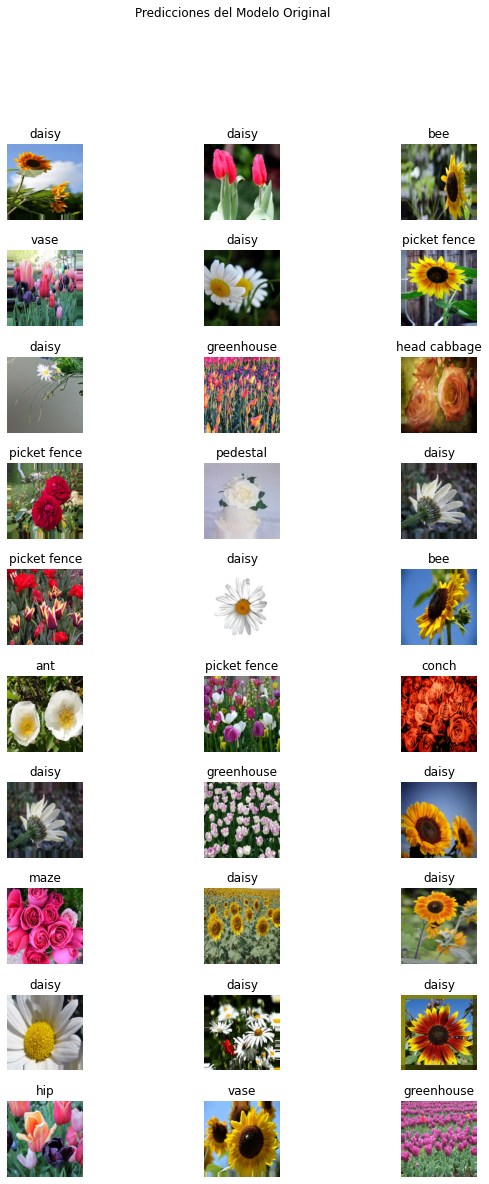

In [13]:
#@title Probar modelo sin re-entrenar

# ejecuta el modelo
result_batch = classifier.predict(image_batch)

# determina resultados
predicted_class_names = model_imagenet_labels[np.argmax(result_batch, axis=-1)]

# muestra resultados
plt.figure(figsize=(10,19))
plt.subplots_adjust(hspace=0.4)
col = 3
rows=len(image_batch)//col

_ = plt.suptitle("Predicciones del Modelo Original")
for n in range(col*rows):
  plt.subplot(rows,col,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')


6) Re-entrenar el modelo:

In [14]:
#@title Preparar el modelo a re-entrenar

# Obtiene el modeo base del modelo para usar en el re-entrenamiento, congelandolo
# y agregandole una nueva capa para aprender las nuevas clases

# Create the feature extractor
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3,))

# It returns a 1280-length vector for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

# Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.
feature_extractor_layer.trainable = False

# Attach a classification head
model = tf.keras.Sequential([ feature_extractor_layer, 
                             layers.Dense(image_data.num_classes, activation='softmax') ])

# Use compile to configure the training process
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'] )

# nuevo modelo a re-entrenar
print("\n")
model.summary()

# info de imágenes a aprender
print("\n")
predictions = model(image_batch)
predictions.shape

(32, 2048)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________




TensorShape([32, 4])

In [15]:
#@title Re-Entrenar

# ejecucuta el re-entrenamiento del modelo

# functions to visualize the training progress
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

# ejecuta el entrenamiento
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=35,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

print("\nModelo re-entrenado")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/35
3/3 [==============================] - 21s 4s/step - loss: 1.4111 - acc: 0.2500
Epoch 2/35
3/3 [==============================] - 2s 627ms/step - loss: 1.1513 - acc: 0.4688
Epoch 3/35
3/3 [==============================] - 2s 630ms/step - loss: 0.6451 - acc: 0.9375
Epoch 4/35
3/3 [==============================] - 2s 633ms/step - loss: 0.6164 - acc: 0.8750
Epoch 5/35
3/3 [==============================] - 2s 731ms/step - loss: 0.5007 - acc: 0.9375
Epoch 6/35
3/3 [==============================] - 2s 615ms/step - loss: 0.3181 - acc: 0.9583
Epoch 7/35
3/3 [==============================] - 2s 710ms/step - loss: 0.3361 - acc: 0.9688
Epoch 8/35
3/3 [==============================] - 2s 717ms/step - loss: 0.2589 - acc: 1.0000
Epoch 9/35
3/3 [==============================] - 2s 623ms/step - loss: 0.2281 - acc: 0.9688
Epoch 10/35
3/3 [==============================] - 2s 728ms/step - loss: 0.2258 - acc: 0.9688
Epoch 11/35
3/3 [==============================] - 2s 628ms/step - loss

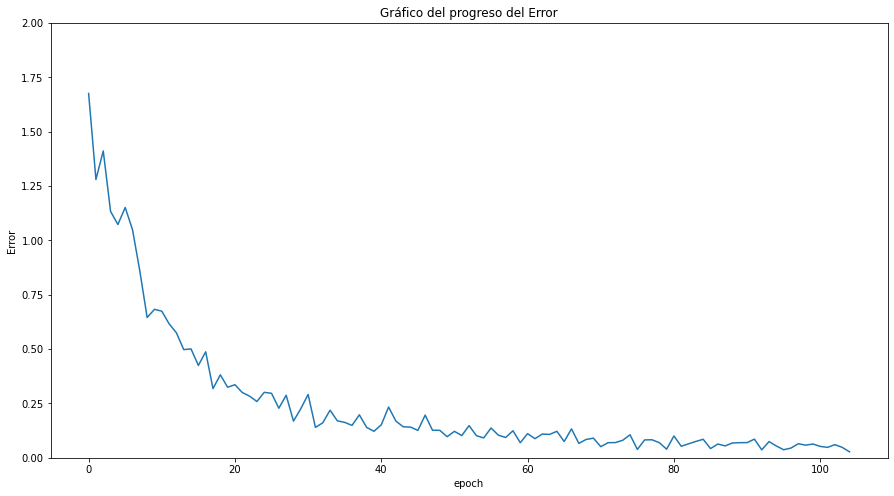

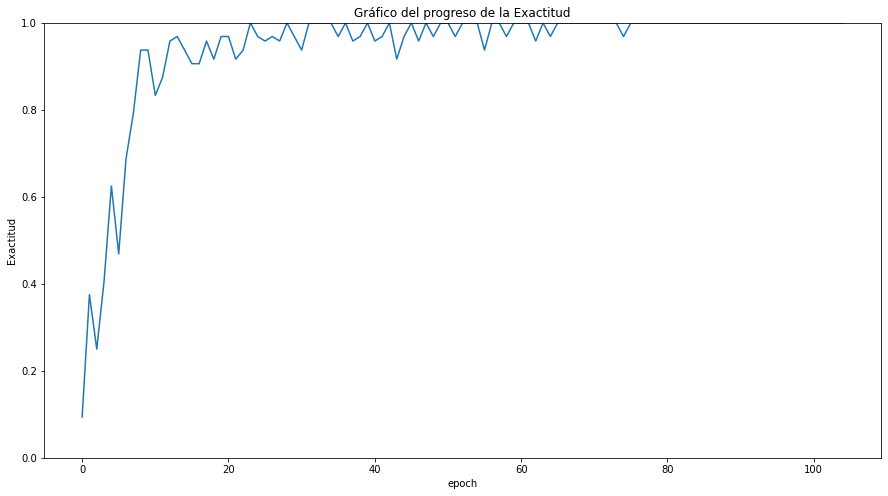

In [16]:
#@title Mostrar gráficos del re-entrenamiento
# muestra gráficos con resultados del re-entrenamiento
plt.figure(figsize=(15,8)) 
plt.title("Gráfico del progreso del Error")
plt.ylabel("Error")
plt.xlabel("epoch")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure(figsize=(15,8)) 
plt.title("Gráfico del progreso de la Exactitud")
plt.ylabel("Exactitud")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

7) Probar nuevo modelo re-entrenado:

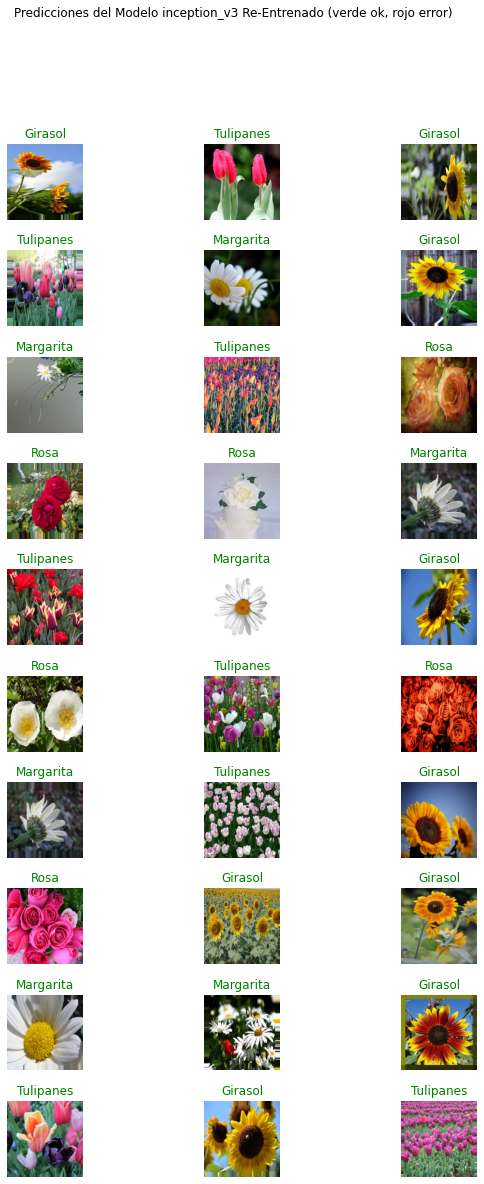

In [17]:
#@title Probar el modelo re-entrenado

# ejecuta el modelo re-entrenado
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

# muestra resultados
plt.figure(figsize=(10,19))
plt.subplots_adjust(hspace=0.4)
col = 3
rows = len(image_batch)//col

for n in range(col*rows):
  plt.subplot(rows,col,n+1)
  plt.imshow(image_batch[n])
  if  predicted_id[n] == label_id[n]:
    color = "green"  
    res = class_names[predicted_id[n]]
  else:
    color = "red"
    res = class_names[predicted_id[n]] + ' [real ' + class_names[label_id[n]] + ']' 

  plt.title(res, color=color)
  plt.axis('off')
_ = plt.suptitle('Predicciones del Modelo ' + modeloUsar + ' Re-Entrenado (verde ok, rojo error)')


8) Grabar el modelo re-entrenado:

In [18]:
#@title Grabar el modelo re-entrenado

# exporta modelo reentrenado
model.save(model_export_path, save_format='tf')
print("\nModelo grabado en ", model_export_path)

# exporta definición de tamaño de imágenes
with open( model_export_path + '/imagshape.csv', mode='w') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(IMAGE_SHAPE)

# exporta definición de las clases
with open( model_export_path + '/clases.csv', mode='w') as csvfile:
    wr = csv.writer(csvfile)
    wr.writerow(class_names)
print('Definición de las clases: ', class_names, ' grabada')


INFO:tensorflow:Assets written to: gdrive/My Drive/IA/demoML/imagenes/FLORES/Model_TFHub/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/IA/demoML/imagenes/FLORES/Model_TFHub/assets



Modelo grabado en  gdrive/My Drive/IA/demoML/imagenes/FLORES/Model_TFHub
Definición de las clases:  ['Girasol' 'Margarita' 'Rosa' 'Tulipanes']  grabada
